<a href="https://colab.research.google.com/github/azilberb/Zilberberg_BIX_F21/blob/main/Homework_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Curiosity" Homework



## Section A - "Choose your fighter"

In this homework, we will be exploring (pun intended) some more agents for the multi-armed bandit task. This assignment will also be a bit more open-ended. Up until now, we have always specified which agents to run, but now you will be tasked with "designing" your own agents. Not from scratch of course, but from the set of building blocks (Actors and Critics) which we established in Lab 4 and Lab 5.

So far we have seen 5 different Actors, which use the estimated values for the different arms to return a selection according to different strategies.

- DeterministicActor
- BoundedRandomActor (parameterized by bound)
- BoundedSequentialActor (parameterized by bound)
- EpsilonActor (parameterized by epsilon)
- SoftmaxActor (parameterized by beta)

We have also seen 3 different Critics, which are responsible for returning the "value" of each arm by combining extrinsic and (possibly) intrinsic values.

- Critic
- CriticUCB
- CriticNovelty

If you do the math, there's 15 possible combinations. Between labs 4 and 5, we have used 7:

- DeterministicActor / Critic
- BoundedRandomActor / Critic
- BoundedSequentialActor / Critic
- EpsilonActor / Critic
- SoftmaxActor / Critic
- DeterministicActor / CriticUCB
- DeterministicActor / CriticNovelty

Our main question: which combinations of Actor and Critic work best?

To help answer this question, we will ask you to select three new combinations to test out. You will be asked to tune your selected agents and run them in different evironments.

### Question 1 [5 pts]

Create a list of three *new* Actor/Critic pairings, which will serve as your agents for the remainder of this assignment.

There's a second restriction we are adding: you can't use the same critic for all three agents.

*EpsilonActor/CriticNovelty, 
EpsilonActor/CriticUCB, 
SoftmaxActor/CriticNovelty*

## Section B - Notebook setup [5 pts]

This lab uses the `DeceptiveBanditOneHigh10` environment (along with the `DeceptiveBanditEnv` parent class), which have been newly ported to explorationlib.  Therefore, you will have to update your personal copy of `local_gym.py` to include these two classes (which can be found in the clappm/explorationlib repo).

Install explorationlib, import the agents/critics/environments, and configure the notebook

In [1]:
# Install explorationlib?
!pip install --upgrade git+https://github.com/azilberb/explorationlib
!pip install --upgrade git+https://github.com/MattChanTK/gym-maze.git

  Cloning https://github.com/azilberb/explorationlib to /tmp/pip-req-build-zf20x83d
  Running command git clone -q https://github.com/azilberb/explorationlib /tmp/pip-req-build-zf20x83d
  Created wheel for explorationlib: filename=explorationlib-0.0.1-py3-none-any.whl size=25265 sha256=b7f9ccfed1672d94057f6af88cc88ad6114c59e4760f168aa5f3ac65377a5c93
  Stored in directory: /tmp/pip-ephem-wheel-cache-5veymikd/wheels/b0/be/67/1b5cb097acfde2d949f722cb16cd4a99d5453ec7ed1b5bd866
Successfully built explorationlib
  Cloning https://github.com/MattChanTK/gym-maze.git to /tmp/pip-req-build-vabgw49l
  Running command git clone -q https://github.com/MattChanTK/gym-maze.git /tmp/pip-req-build-vabgw49l
     |████████████████████████████████| 18.3 MB 109 kB/s 
  Created wheel for gym-maze: filename=gym_maze-0.4-py3-none-any.whl size=14241 sha256=8748b9b97a3761b9c0eeb207868f08d11127f761020ad0bbf15b244ff2545548
  Stored in directory: /tmp/pip-ephem-wheel-cache-aw_id3dn/wheels/01/f8/86/0dd8c448e192abff0

In [2]:
# import basic modules
import shutil
import glob
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# import explorationlib
import explorationlib

# import the type of environment we will be using
from explorationlib.local_gym import BanditUniform4
from explorationlib.local_gym import BanditUniform10
from explorationlib.local_gym import DeceptiveBanditOneHigh10

# import the components to build our agents
from explorationlib.agent import BanditActorCritic

from explorationlib.agent import Critic
from explorationlib.agent import CriticUCB
from explorationlib.agent import CriticNovelty

from explorationlib.agent import EpsilonActor
from explorationlib.agent import DeterministicActor
#from explorationlib.agent import RandomActor
#from explorationlib.agent import SequentialActor
from explorationlib.agent import BoundedRandomActor
from explorationlib.agent import BoundedSequentialActor
from explorationlib.agent import SoftmaxActor

# import the experimental framework
from explorationlib.run import experiment

# import some scoring functions
from explorationlib.score import total_reward
from explorationlib.score import action_entropy

# import some utility functions
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

# import some plotting functions
from explorationlib.plot import plot_bandit
from explorationlib.plot import plot_bandit_actions
from explorationlib.plot import plot_bandit_critic
from explorationlib.plot import plot_bandit_hist

pygame 2.1.0 (SDL 2.0.16, Python 3.7.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
# Pretty plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

# Dev
%load_ext autoreload
%autoreload 2

## Section C - Four-arm bandits [40 pts total]



We will first consider the 4-arm environment we've used several times before.

### Creating the training environment

It's always good practice to test your agents on a different environment than the one on which they were trained.  For now we will create a training environment.

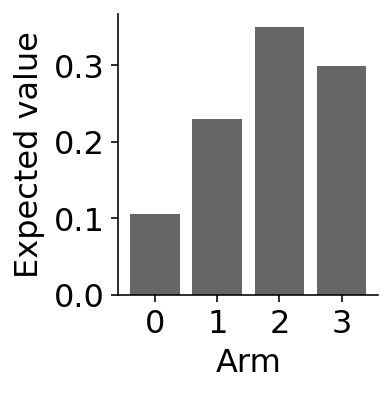

In [4]:
# don't touch
# Shared env params
seed = 412
num_steps = 400

# Create env
env = BanditUniform4(p_min=0.1, p_max=0.3, p_best=0.35)
env.seed(seed)

# Plot env
plot_bandit(env, alpha=0.6)

### Question 2 [15 pts]

How do you expect your agents to perform relative to each other, in a 4-arm environment after they have been tuned? Which one will do best and which one will do worst?  Please explain your ranking, *considering the functionality and contributions of both the Actor and Critic components of each agent*. To help justify your hypothesis, it will be useful to briefly reference previous simulations and results (Labs 4/5 and HW 4).

I think the one pair with the UCB critic will do best because the UCB critic tends to be better, beyond that it is likely that the tuned epsilon agent will be better than the softmax agent.

### Tuning Agent 1 for 4-armed bandit [5 pts]

Each of your agents should have 1 tunable parameter.  The name and functionality of this parameter depends on which Actors you selected. For this homework, we are not going to be tuning the Critic in any way, we will simply be using the default parameters. The examples from Lab 5 should show you how to create an agent from a combination of Actor and Critic.

First tune the parameter of Agent 1, whatever it may be, using the training environment we've established. Show your different simulation batches and plots in different cells so that we may see your work.  The exact process by which you tune your agents is up to you.

We understand that tuning can be tedious... we are not asking for perfection. We don't have an answer key for parameter values. The goal is just for you to find parameters that are *good enough* so that the comparison between agents can be considered fair.

In [8]:
epsilonNovelty_1 = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=0),
    CriticNovelty(num_inputs=env.num_arms, default_value=0.0)
)

epsilonNovelty_2 = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=0.05),
    CriticNovelty(num_inputs=env.num_arms, default_value=0.0)
)

epsilonNovelty_3 = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=0.1),
    CriticNovelty(num_inputs=env.num_arms, default_value=0.0)
)

epsilonNovelty_4 = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=0.15),
    CriticNovelty(num_inputs=env.num_arms, default_value=0.0)
)

epsilonNovelty_5 = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=0.2),
    CriticNovelty(num_inputs=env.num_arms, default_value=0.0)
)

# organize them
agents = [epsilonNovelty_1, epsilonNovelty_2, epsilonNovelty_3, epsilonNovelty_4, epsilonNovelty_5]
names = ["e1", "e2", "e3", "e4", "e5"]
colors = ["blue", "green", "purple", "red", "orange", "yellow"]

In [9]:
num_steps = 400
num_experiments = 400

# !
results = []
for name, agent in zip(names, agents):
    log = experiment(
        f"{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=False,
    )
    results.append(log)

e1:   0%|          | 0/400 [00:00<?, ?it/s]

e2:   0%|          | 0/400 [00:00<?, ?it/s]

e3:   0%|          | 0/400 [00:00<?, ?it/s]

e4:   0%|          | 0/400 [00:00<?, ?it/s]

e5:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

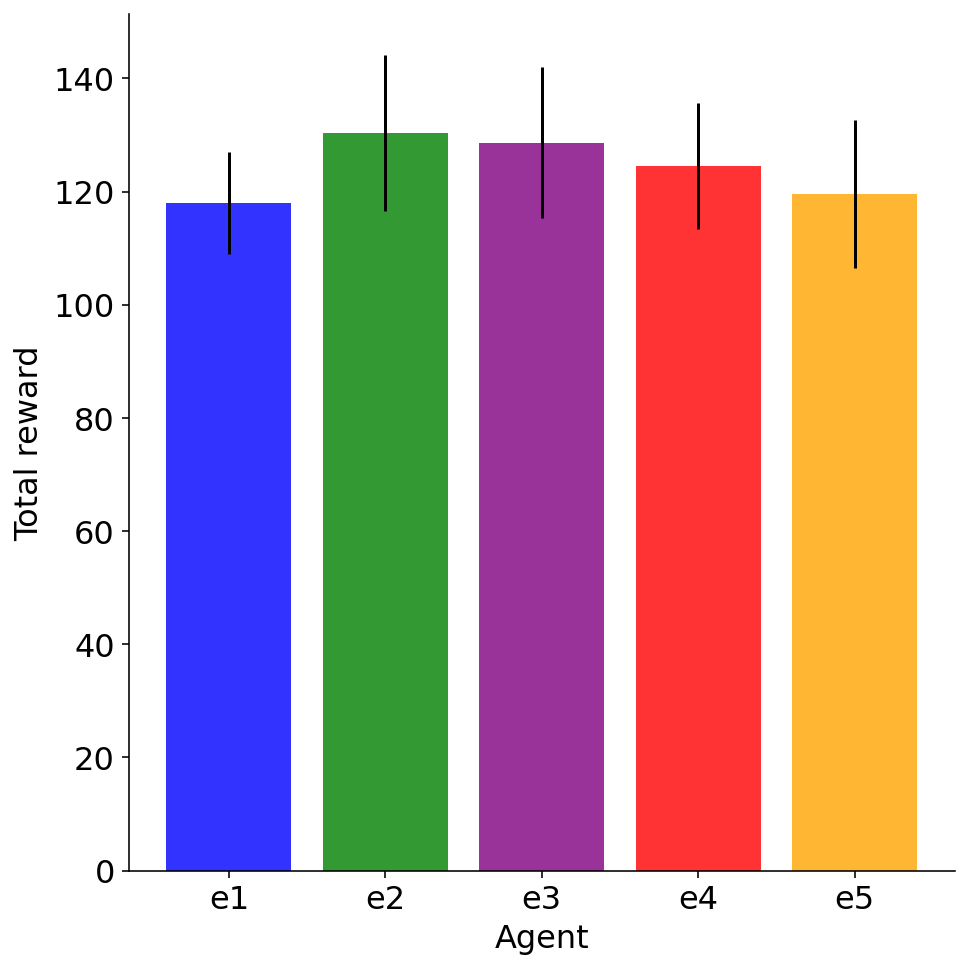

In [10]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(7, 7))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.8)
plt.ylabel("Total reward")
plt.xlabel("Agent")
plt.tight_layout()
sns.despine()

What parameter value did you you settle on for Agent 1?

I settled on epsilon = 0.05 for Epsilon/CriticNovelty

### Tuning Agent 2 for 4-armed bandit [5 pts]

In [11]:
epsilonUCB_1 = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=0),
    CriticUCB(num_inputs=env.num_arms, default_value=0.0)
)
epsilonUCB_2 = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=0.05),
    CriticUCB(num_inputs=env.num_arms, default_value=0.0)
)
epsilonUCB_3 = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=0.1),
    CriticUCB(num_inputs=env.num_arms, default_value=0.0)
)
epsilonUCB_4 = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=0.15),
    CriticUCB(num_inputs=env.num_arms, default_value=0.0)
)
epsilonUCB_5 = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=0.2),
    CriticUCB(num_inputs=env.num_arms, default_value=0.0)
)

# organize them
agents = [epsilonUCB_1, epsilonUCB_2, epsilonUCB_3, epsilonUCB_4, epsilonUCB_5]
names = ["e1", "e2", "e3", "e4", "e5"]
colors = ["blue", "green", "purple", "red", "orange", "yellow"]

In [12]:
num_steps = 400
num_experiments = 400

# !
results = []
for name, agent in zip(names, agents):
    log = experiment(
        f"{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=False,
    )
    results.append(log)

e1:   0%|          | 0/400 [00:00<?, ?it/s]

e2:   0%|          | 0/400 [00:00<?, ?it/s]

e3:   0%|          | 0/400 [00:00<?, ?it/s]

e4:   0%|          | 0/400 [00:00<?, ?it/s]

e5:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

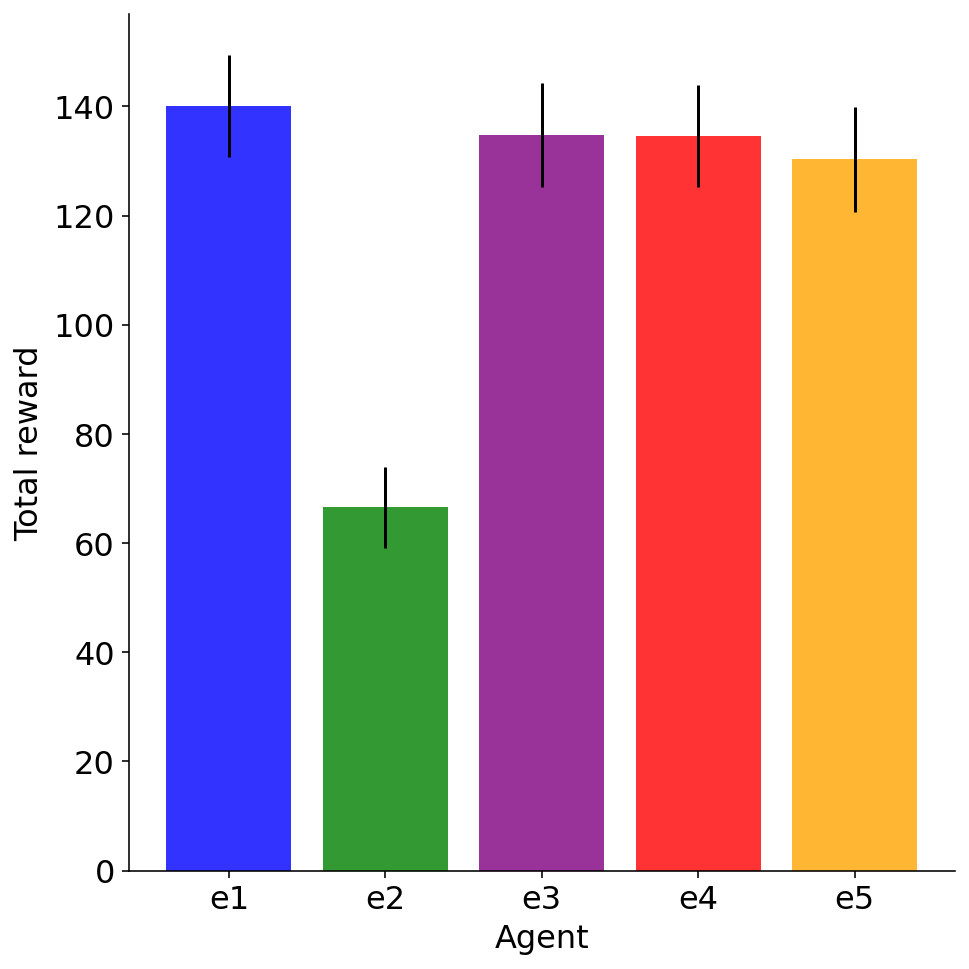

In [13]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(7, 7))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.8)
plt.ylabel("Total reward")
plt.xlabel("Agent")
plt.tight_layout()
sns.despine()

What parameter value did you you settle on for Agent 2?

epsilon = 0 for Epsilon/CriticUCB

### Tuning Agent 3 for 4-armed bandit [5 pts]

In [14]:
softmaxNovelty_1 = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=0),
    CriticNovelty(num_inputs=env.num_arms, default_value=0.0)
)
softmaxNovelty_2 = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=.5),
    CriticNovelty(num_inputs=env.num_arms, default_value=0.0)
)
softmaxNovelty_3 = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=1),
    CriticNovelty(num_inputs=env.num_arms, default_value=0.0)
)
softmaxNovelty_4 = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=1.5),
    CriticNovelty(num_inputs=env.num_arms, default_value=0.0)
)
softmaxNovelty_5 = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=2),
    CriticNovelty(num_inputs=env.num_arms, default_value=0.0)
)

# organize them
agents = [softmaxNovelty_1, softmaxNovelty_2, softmaxNovelty_3, softmaxNovelty_4, softmaxNovelty_5]
names = ["s1", "s2", "s3", "s4", "s5"]
colors = ["blue", "green", "purple", "red", "orange", "yellow"]

In [15]:
num_steps = 400
num_experiments = 400

# !
results = []
for name, agent in zip(names, agents):
    log = experiment(
        f"{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=False,
    )
    results.append(log)

s1:   0%|          | 0/400 [00:00<?, ?it/s]

s2:   0%|          | 0/400 [00:00<?, ?it/s]

s3:   0%|          | 0/400 [00:00<?, ?it/s]

s4:   0%|          | 0/400 [00:00<?, ?it/s]

s5:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

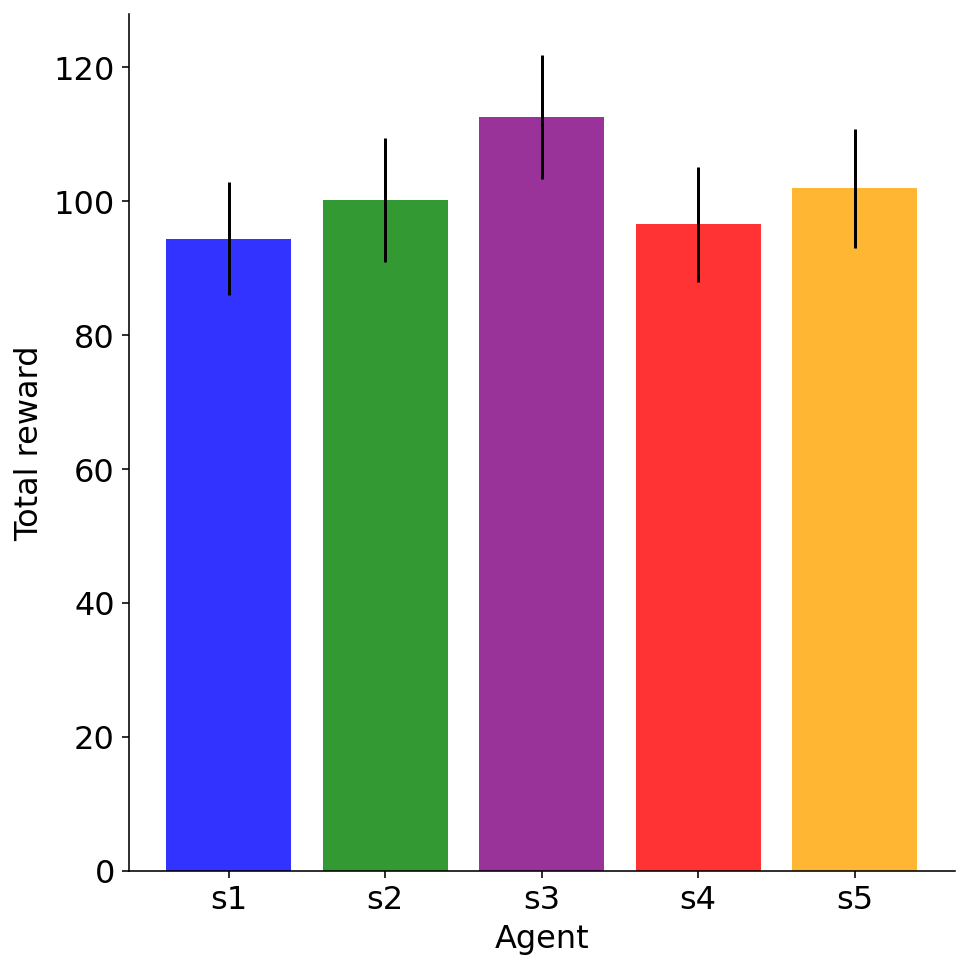

In [16]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(7, 7))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.8)
plt.ylabel("Total reward")
plt.xlabel("Agent")
plt.tight_layout()
sns.despine()

What parameter value did you you settle on for Agent 3?

beta = 1 for softmax/CriticNovelty

### Creating a testing environment

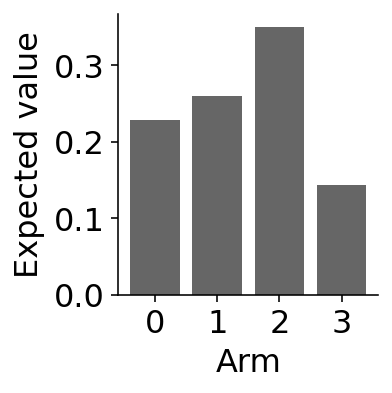

In [17]:
# don't touch
# Shared env params
seed = 15213
num_steps = 400

# Create env
env = BanditUniform4(p_min=0.1, p_max=0.3, p_best=0.35)
env.seed(seed)

# Plot env
plot_bandit(env, alpha=0.6)

### Run 400 experiments and plot the average rewards for the 3 agents [5 pts]

In [18]:
epsilonNovelty = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=0.05),
    CriticNovelty(num_inputs=env.num_arms, default_value=0.0)
)

epsilonUCB = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=0),
    CriticUCB(num_inputs=env.num_arms, default_value=0.0)
)

softmaxNovelty = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=1),
    CriticNovelty(num_inputs=env.num_arms, default_value=0.0)
)

# organize them
agents = [epsilonNovelty, epsilonUCB, softmaxNovelty]
names = ["eN", "eU", "sN"]
colors = ["blue", "green", "purple"]

In [19]:
num_steps = 400
num_experiments = 400

# !
results = []
for name, agent in zip(names, agents):
    log = experiment(
        f"{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=False,
    )
    results.append(log)

eN:   0%|          | 0/400 [00:00<?, ?it/s]

eU:   0%|          | 0/400 [00:00<?, ?it/s]

sN:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

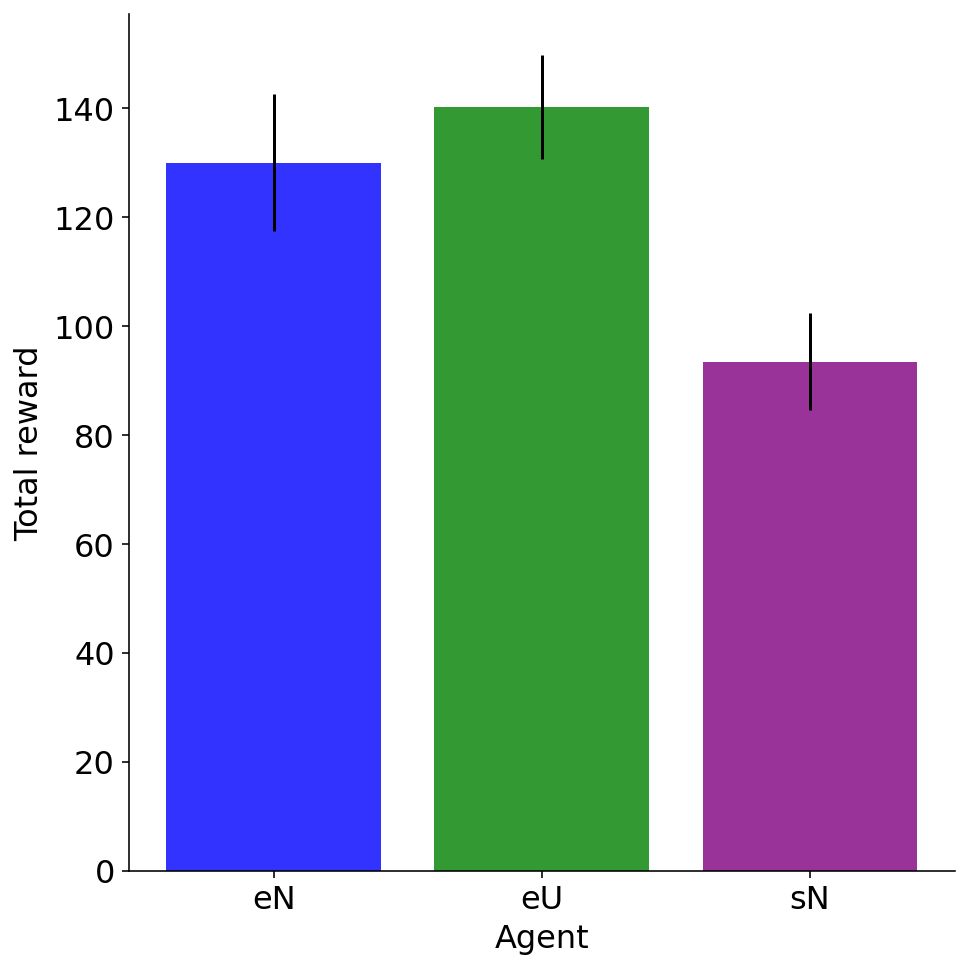

In [20]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(7, 7))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.8)
plt.ylabel("Total reward")
plt.xlabel("Agent")
plt.tight_layout()
sns.despine()

### Question 3 [5 pts]

Did your results match what you predicted in Question 2? If not, do you have any ideas as to why?

Yes actually! It was exactly as I predicted, though honestly I did not think there would be that big of a difference between the 3.

## Section D - Deceptive bandits [50 pts total]

We will now consider the same types of agents placed into a different type of environment: the deceptive bandit.

### Creating the training environment

We are going to retune our agents, but we're not going to tune them against the deceptive bandit (or else it wouldn't be very deceptive, would it?).  Instead we are going to tune them against the non-deceptive 10-arm bandit from lab, which is identical to the deceptive bandit in terms of arm values but without the deception.

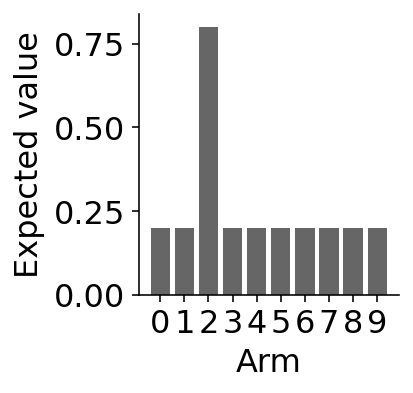

In [21]:
# don't touch
# Shared env params
seed = 503
num_steps = 400

# Create env
env = BanditUniform10(p_min=0.2, p_max=0.2, p_best=0.8)
env.seed(seed)

# Plot env
plot_bandit(env, alpha=0.6)

### Question 4 [15 pts]

How well do you expect your agents to perform in the deceptive 10-arm environment, after being tuned in the non-deceptive environment?  Which one will score the highest and which one will score the lowest?

Similar to when you made a hypothesis in Section C, explain your answer fully.  Base it on your understanding of the properties of the actors and critics, as well as the results in lab. Consider the possible weaknesses of the agents, such as how certain parameter values might allow the agents to perform better in training but also cause the agents to be more easily deceived.

I am gonna be honest I am very sick and want to go to sleep so I am going to skip this question and just crank out as much of this as I can.

### Tuning Agent 1 for 10-armed bandit [5 pts]

The process for tuning agents here should be roughly the same as in Section C.

e1:   0%|          | 0/400 [00:00<?, ?it/s]

e2:   0%|          | 0/400 [00:00<?, ?it/s]

e3:   0%|          | 0/400 [00:00<?, ?it/s]

e4:   0%|          | 0/400 [00:00<?, ?it/s]

e5:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

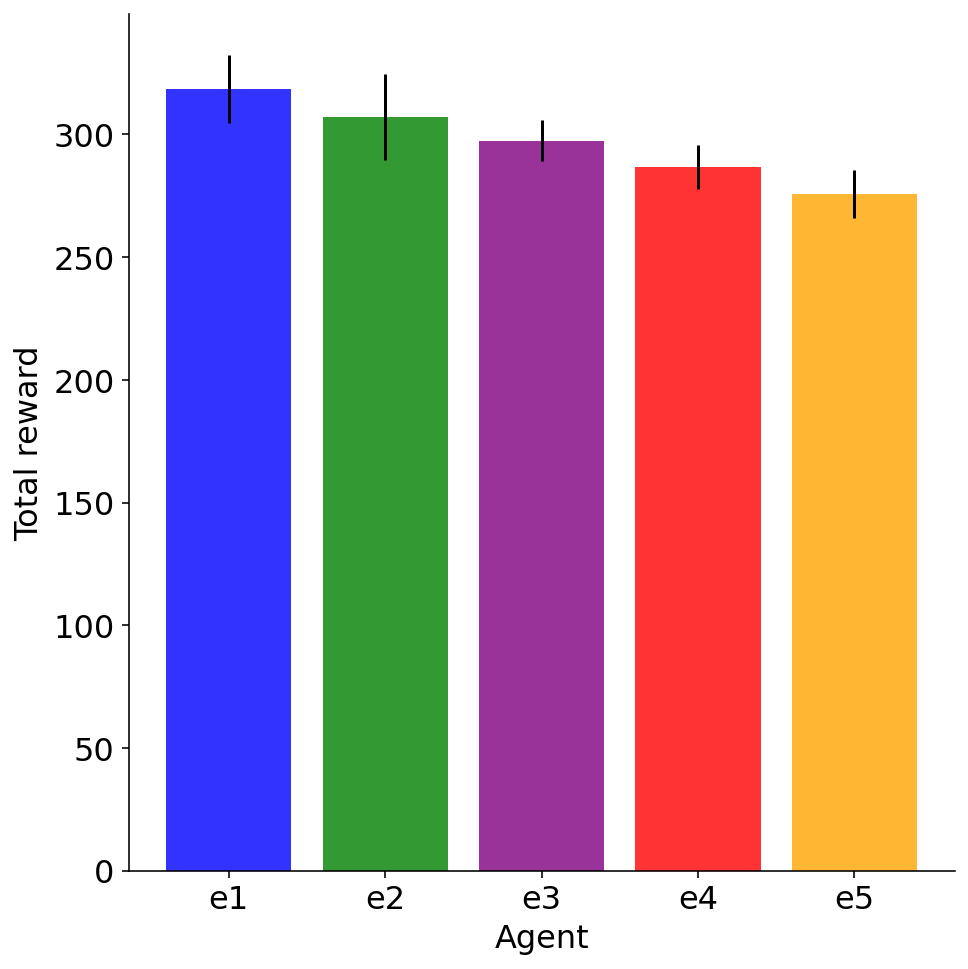

In [22]:
epsilonNovelty_1 = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=0),
    CriticNovelty(num_inputs=env.num_arms, default_value=0.0)
)

epsilonNovelty_2 = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=0.05),
    CriticNovelty(num_inputs=env.num_arms, default_value=0.0)
)

epsilonNovelty_3 = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=0.1),
    CriticNovelty(num_inputs=env.num_arms, default_value=0.0)
)

epsilonNovelty_4 = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=0.15),
    CriticNovelty(num_inputs=env.num_arms, default_value=0.0)
)

epsilonNovelty_5 = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=0.2),
    CriticNovelty(num_inputs=env.num_arms, default_value=0.0)
)

# organize them
agents = [epsilonNovelty_1, epsilonNovelty_2, epsilonNovelty_3, epsilonNovelty_4, epsilonNovelty_5]
names = ["e1", "e2", "e3", "e4", "e5"]
colors = ["blue", "green", "purple", "red", "orange", "yellow"]

num_steps = 400
num_experiments = 400

# !
results = []
for name, agent in zip(names, agents):
    log = experiment(
        f"{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=False,
    )
    results.append(log)

# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(7, 7))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.8)
plt.ylabel("Total reward")
plt.xlabel("Agent")
plt.tight_layout()
sns.despine()

What parameter value did you you settle on for Agent 1?

epsilon = 0 for Epsilon/CriticNovelty

### Tuning Agent 2 for 10-armed bandit [5 pts]

e1:   0%|          | 0/400 [00:00<?, ?it/s]

e2:   0%|          | 0/400 [00:00<?, ?it/s]

e3:   0%|          | 0/400 [00:00<?, ?it/s]

e4:   0%|          | 0/400 [00:00<?, ?it/s]

e5:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

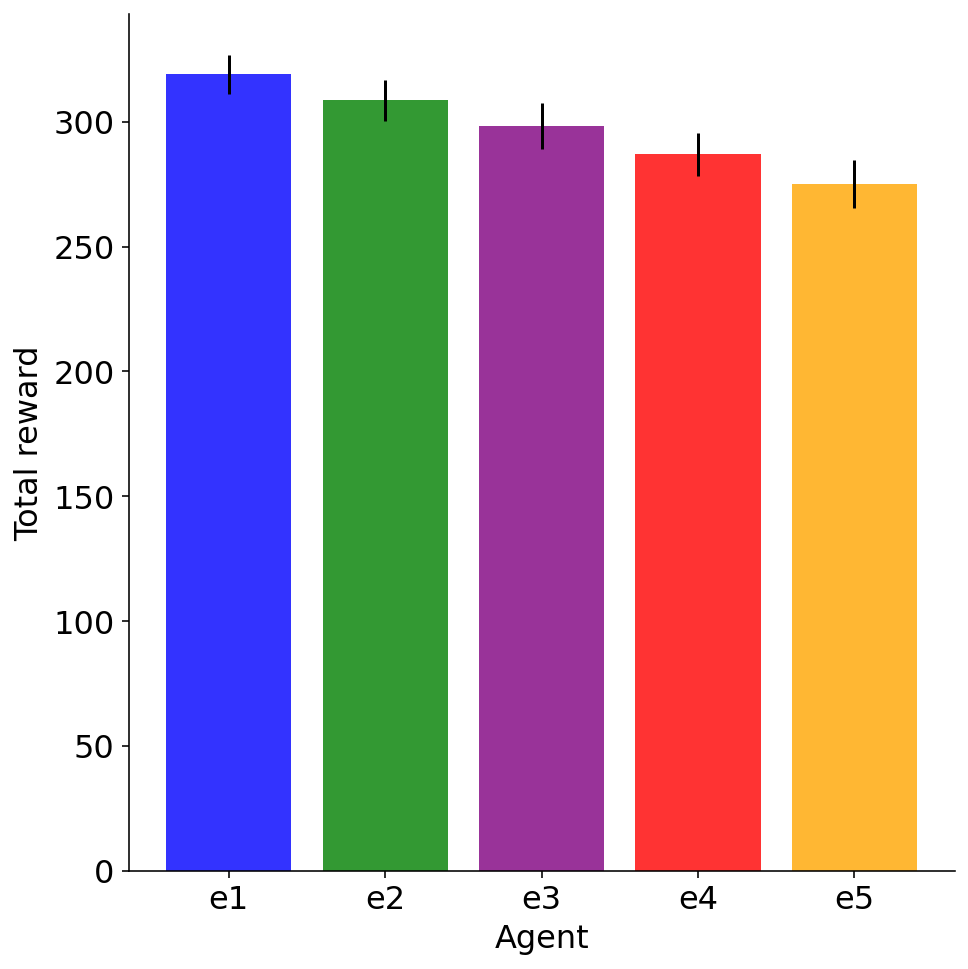

In [23]:
epsilonUCB_1 = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=0),
    CriticUCB(num_inputs=env.num_arms, default_value=0.0)
)
epsilonUCB_2 = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=0.05),
    CriticUCB(num_inputs=env.num_arms, default_value=0.0)
)
epsilonUCB_3 = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=0.1),
    CriticUCB(num_inputs=env.num_arms, default_value=0.0)
)
epsilonUCB_4 = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=0.15),
    CriticUCB(num_inputs=env.num_arms, default_value=0.0)
)
epsilonUCB_5 = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=0.2),
    CriticUCB(num_inputs=env.num_arms, default_value=0.0)
)

# organize them
agents = [epsilonUCB_1, epsilonUCB_2, epsilonUCB_3, epsilonUCB_4, epsilonUCB_5]
names = ["e1", "e2", "e3", "e4", "e5"]
colors = ["blue", "green", "purple", "red", "orange", "yellow"]

num_steps = 400
num_experiments = 400

# !
results = []
for name, agent in zip(names, agents):
    log = experiment(
        f"{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=False,
    )
    results.append(log)

# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(7, 7))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.8)
plt.ylabel("Total reward")
plt.xlabel("Agent")
plt.tight_layout()
sns.despine()

What parameter value did you you settle on for Agent 2?

epsilon = 0 for Epsilon/CriticUCB

### Tuning Agent 3 for 10-armed bandit [5 pts]

s1:   0%|          | 0/400 [00:00<?, ?it/s]

s2:   0%|          | 0/400 [00:00<?, ?it/s]

s3:   0%|          | 0/400 [00:00<?, ?it/s]

s4:   0%|          | 0/400 [00:00<?, ?it/s]

s5:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

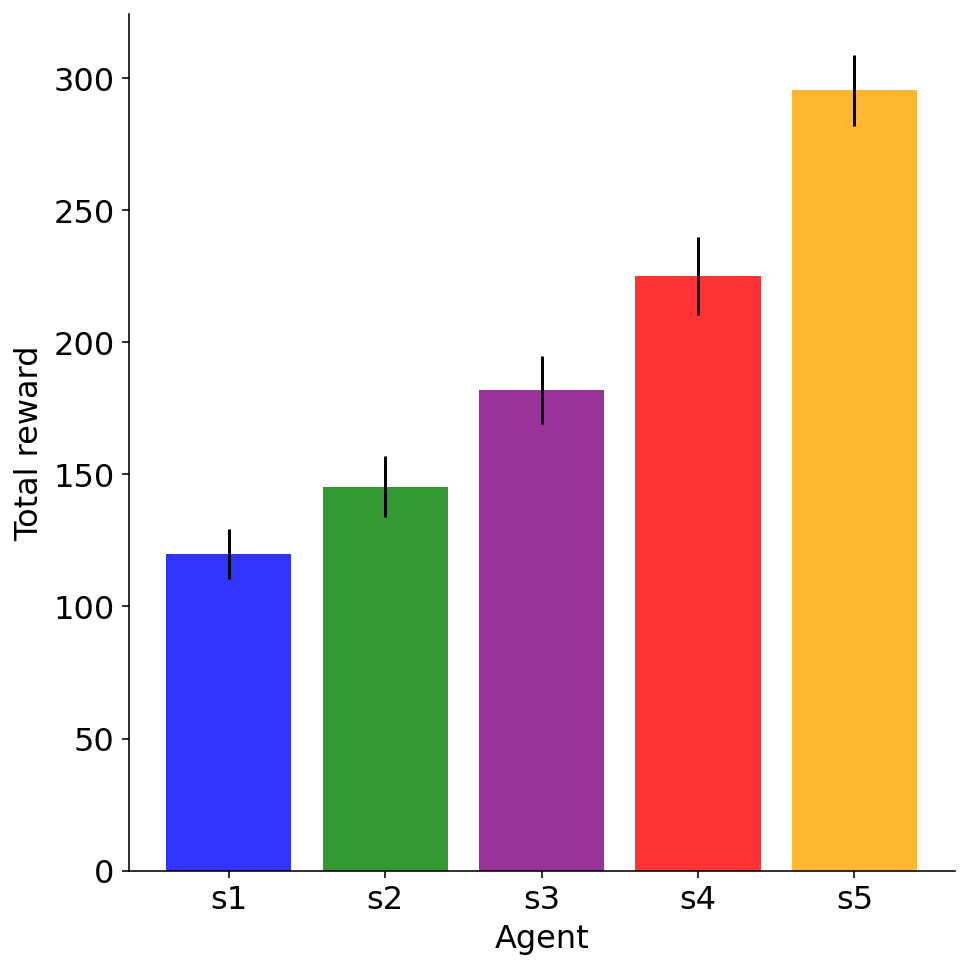

In [25]:
softmaxNovelty_1 = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=1),
    CriticNovelty(num_inputs=env.num_arms, default_value=0.0)
)
softmaxNovelty_2 = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=2),
    CriticNovelty(num_inputs=env.num_arms, default_value=0.0)
)
softmaxNovelty_3 = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=3),
    CriticNovelty(num_inputs=env.num_arms, default_value=0.0)
)
softmaxNovelty_4 = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=4),
    CriticNovelty(num_inputs=env.num_arms, default_value=0.0)
)
softmaxNovelty_5 = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=5),
    CriticNovelty(num_inputs=env.num_arms, default_value=0.0)
)

# organize them
agents = [softmaxNovelty_1, softmaxNovelty_2, softmaxNovelty_3, softmaxNovelty_4, softmaxNovelty_5]
names = ["s1", "s2", "s3", "s4", "s5"]
colors = ["blue", "green", "purple", "red", "orange", "yellow"]

num_steps = 400
num_experiments = 400

# !
results = []
for name, agent in zip(names, agents):
    log = experiment(
        f"{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=False,
    )
    results.append(log)

# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(7, 7))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.8)
plt.ylabel("Total reward")
plt.xlabel("Agent")
plt.tight_layout()
sns.despine()

s1:   0%|          | 0/400 [00:00<?, ?it/s]

s2:   0%|          | 0/400 [00:00<?, ?it/s]

s3:   0%|          | 0/400 [00:00<?, ?it/s]

s4:   0%|          | 0/400 [00:00<?, ?it/s]

s5:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

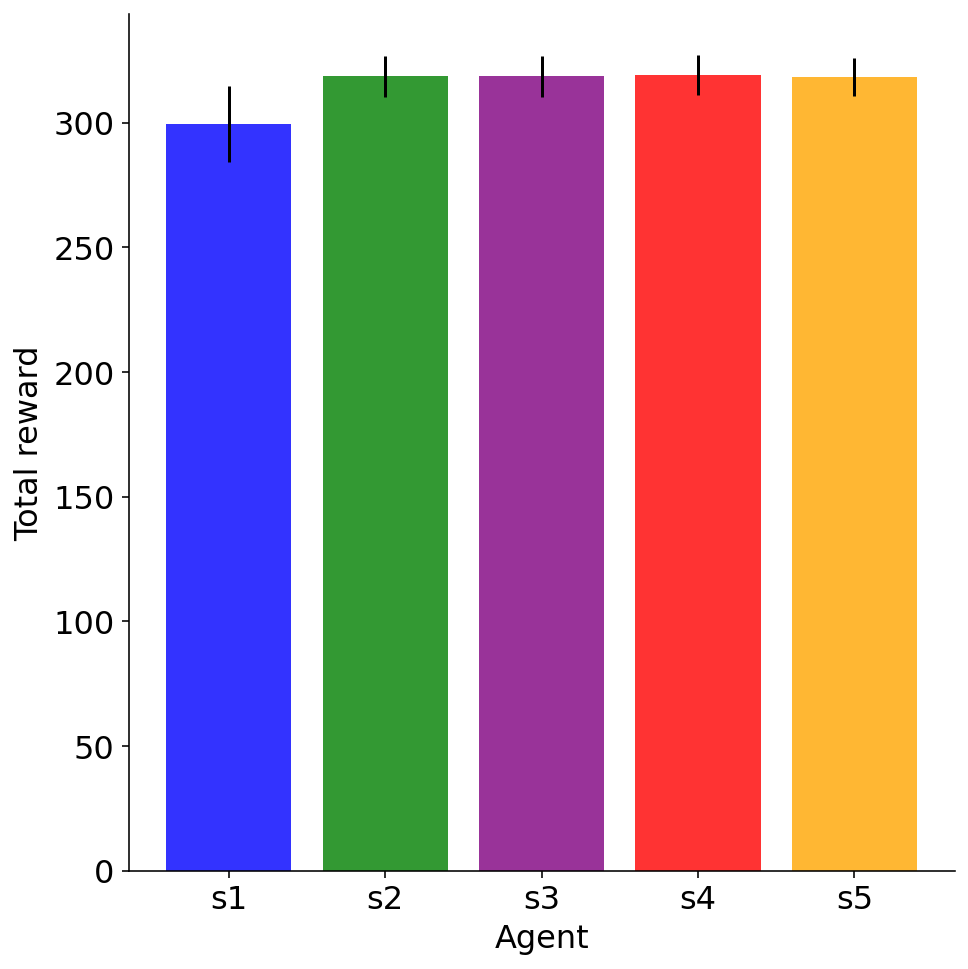

In [26]:
softmaxNovelty_1 = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=5),
    CriticNovelty(num_inputs=env.num_arms, default_value=0.0)
)
softmaxNovelty_2 = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=6),
    CriticNovelty(num_inputs=env.num_arms, default_value=0.0)
)
softmaxNovelty_3 = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=7),
    CriticNovelty(num_inputs=env.num_arms, default_value=0.0)
)
softmaxNovelty_4 = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=8),
    CriticNovelty(num_inputs=env.num_arms, default_value=0.0)
)
softmaxNovelty_5 = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=9),
    CriticNovelty(num_inputs=env.num_arms, default_value=0.0)
)

# organize them
agents = [softmaxNovelty_1, softmaxNovelty_2, softmaxNovelty_3, softmaxNovelty_4, softmaxNovelty_5]
names = ["s1", "s2", "s3", "s4", "s5"]
colors = ["blue", "green", "purple", "red", "orange", "yellow"]

num_steps = 400
num_experiments = 400

# !
results = []
for name, agent in zip(names, agents):
    log = experiment(
        f"{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=False,
    )
    results.append(log)

# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(7, 7))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.8)
plt.ylabel("Total reward")
plt.xlabel("Agent")
plt.tight_layout()
sns.despine()

What parameter value did you you settle on for Agent 3?

Surprised how much this changed honestly... beta = 8 for softmax/CriticNovelty

### Creating a testing (deceptive) environment

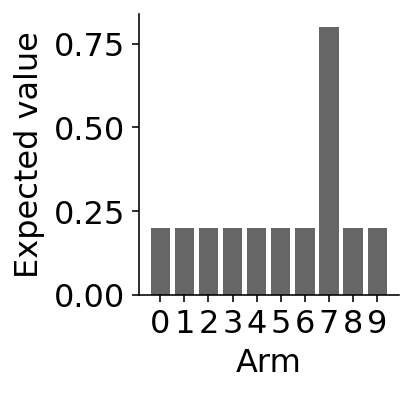

In [27]:
# don't touch
# Shared env params
seed = 15213
num_steps = 400

# Create env
env = DeceptiveBanditOneHigh10()
env.seed(seed)

# Plot env
plot_bandit(env, alpha=0.6)

### Run 400 experiments and plot the average rewards for the 3 agents [5 pts]

eN:   0%|          | 0/400 [00:00<?, ?it/s]

eU:   0%|          | 0/400 [00:00<?, ?it/s]

sN:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

total_reward:   0%|          | 0/400 [00:00<?, ?it/s]

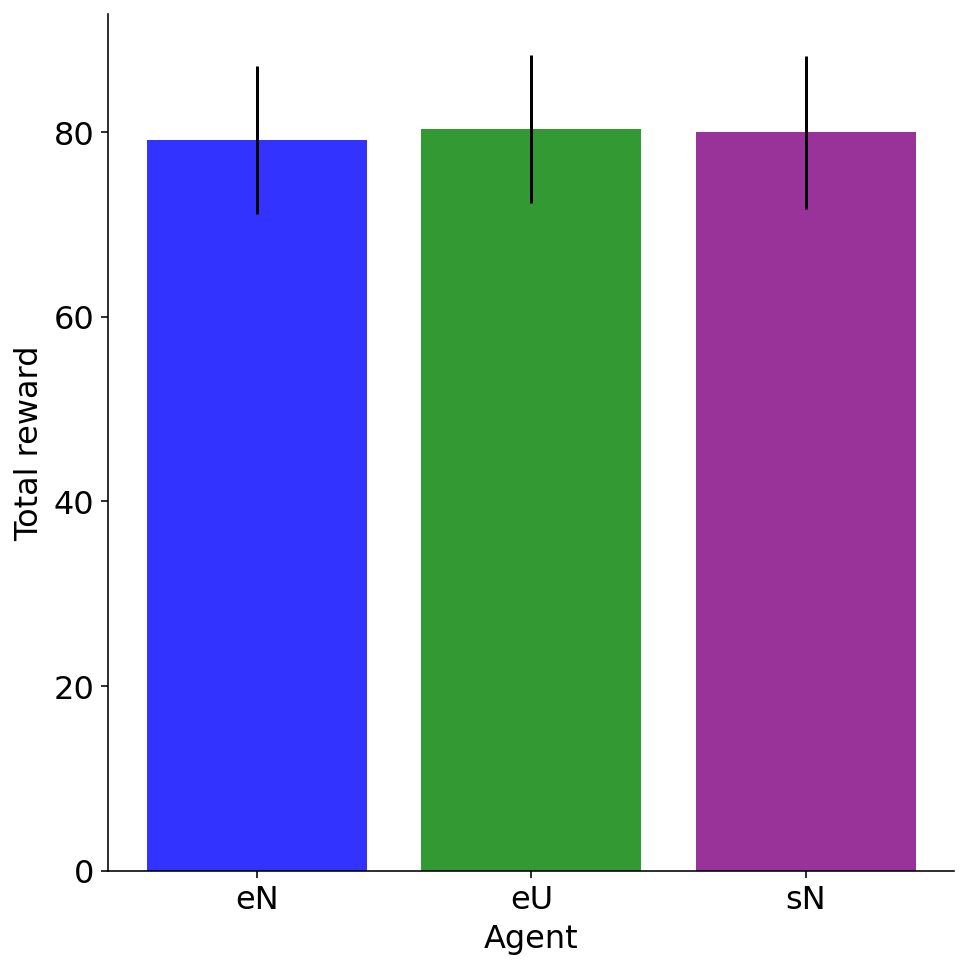

In [28]:
epsilonNovelty = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=0),
    CriticNovelty(num_inputs=env.num_arms, default_value=0.0)
)

epsilonUCB = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=0),
    CriticUCB(num_inputs=env.num_arms, default_value=0.0)
)

softmaxNovelty = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=8),
    CriticNovelty(num_inputs=env.num_arms, default_value=0.0)
)

# organize them
agents = [epsilonNovelty, epsilonUCB, softmaxNovelty]
names = ["eN", "eU", "sN"]
colors = ["blue", "green", "purple"]

num_steps = 400
num_experiments = 400

# !
results = []
for name, agent in zip(names, agents):
    log = experiment(
        f"{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=False,
    )
    results.append(log)

# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(7, 7))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.8)
plt.ylabel("Total reward")
plt.xlabel("Agent")
plt.tight_layout()
sns.despine()

### Question 5 [5 pts]

Did your results match what you predicted in Question 4? If not, do you have any ideas as to why?

Skipping this question as well since I did not make predictions :(

### Question 6 [10 pts]

Time for some conclusions. Was there a clear winner among your three selected agents?  Was there one which performed the best against both non-deceptive and deceptive bandits?  Or did different agents perform better or worse in different scenarios?  Which agent would you pick as your favorite?

They were all approximetely the same with the Epsilon/CriticUCB being a little higher and Epsilon/CriticNovelty being the lowest.

I would definitely choose the Epsilon/CriticUCB with an epsilon of 0 as it seemed to preform best in both scenerios.

## Submission

**DUE:** 5pm EST, Nov 30, 2021. Email the link to the completed notebook on your Github repository to the TA and me via Canvas.

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here. 
> *Someone's Name*